In [ ]:
import pickle
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.express as px
from tqdm.notebook import tqdm

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans, AgglomerativeClustering, DBSCAN

from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

class BaseClusteringExperiment:
    
    images_paths_filename = 'images_paths.csv'
    base_images_path = ['raw_data', 'veriwild']
    
    def __init__(self, descriptor_file="descriptors/efficientnet-b7.pickle", preprocess_pca_dim=200, n_clusters=8, descriptor=None):
        self.n_clusters = n_clusters
        self.descriptor_file = descriptor_file
        self.preprocess_pca_dim = preprocess_pca_dim
        
        if descriptor is not None:
            self.descriptor = descriptor
        else:
            self.descriptor = self._build_descriptor()
        
        self.images_paths = self._build_images_paths()
        
        self._labels = None
        
        self.model = self._build_model()
        
        return
    
    def _build_descriptor(self):
        print("loading descriptor", self.descriptor_file)
        with open(self.descriptor_file, 'rb') as f:
            descriptor = pickle.load(f)
        return descriptor
    
    def _build_images_paths(self):
        images_paths = pd.read_csv(self.images_paths_filename)
        # fix os separator
        images_paths['paths'] = images_paths['paths'].apply(lambda x: os.path.join(* (self.base_images_path + x.split("\\")) ))
        return images_paths
    
    def draw_samples(self, samples_indexes):
        paths = self.images_paths.iloc[samples_indexes]['paths']
        
        for i, path in enumerate(paths):
            plt.figure(i)
            img = mpimg.imread(path)
            plt.imshow(img)
        
        return
    
    def labels(self):
        if self._labels is None:
            self._labels = self.clustering()
        return self._labels
    
    def _build_model(self):
        raise NotImplemented
    
    def clustering(self):
        self._clustering_preprocess()
        
#         step = 5000
        print("fitting model...")
#         for i in tqdm(range(0, self.descriptor.shape[0], step)):
#             partial_fit_batch = self.descriptor[i:i+step]
        self.model.fit( self.descriptor )
        
        return self.model.predict( self.descriptor )
    
    def draw_clustered(self):
        image_pca = PCA(n_components=2, copy=True)
        descriptor_pcaed = image_pca.fit_transform( self.descriptor )
        
        labels = np.expand_dims(self.labels(), axis=1)
        data_transformed_df = pd.DataFrame(np.hstack([descriptor_pcaed, labels]), columns=['x', 'y', 'cluster'])
        data_transformed_df['cluster'] = data_transformed_df['cluster'].astype(str)
        fig = px.scatter(data_transformed_df, x='x', y='y', color='cluster')
        fig.show()
        
        return
    
    def count_metrics(self):
        # todo количество объектов в разных кластерах
        return {
            "calinski_harabasz_score": calinski_harabasz_score(self.descriptor, self.labels()),
            "davies_bouldin_score": davies_bouldin_score(self.descriptor, self.labels()),
        }
    
    def report_experiment(self):
        print(self.count_metrics())
        self.draw_clustered()
        return
        
    def _clustering_preprocess(self):
        
        if self.descriptor.shape[1] <= self.preprocess_pca_dim:
            return
        
        print("performing preprocess PCA...")
        pca = PCA(n_components=self.preprocess_pca_dim, copy=False)
        descriptor_pcaed = pca.fit_transform(self.descriptor)
        print("self.descriptor.shape", self.descriptor.shape, "descriptor_pcaed.shape", descriptor_pcaed.shape)
        self.descriptor = descriptor_pcaed

        return
    
    
class MiniBatchKMeansClusteringExperiment(BaseClusteringExperiment):
    def _build_model(self):
        return MiniBatchKMeans(n_clusters=self.n_clusters, random_state=0, batch_size=500)
    
class KMeansClusteringExperiment(BaseClusteringExperiment):
    def _build_model(self):
        return KMeans(n_clusters=self.n_clusters, random_state=0)
    
class DBSCANClusteringExperiment(BaseClusteringExperiment):
    def _build_model(self):
        return DBSCAN(eps=0.5, min_samples=5, metric='euclidean', n_jobs=-1)
    

In [5]:
descriptors_files = [ 'descriptors/efficientnet-b7.pickle', 'descriptors/vdc_color.pickle', 'descriptors/vdc_type.pickle' ]

for desc_file in descriptors_files:
    base_exp = KMeansClusteringExperiment(descriptor_file=desc_file)
    base_exp._clustering_preprocess()
    
    desc_file_name_200 = desc_file.replace('.pickle', f'{base_exp.descriptor.shape[1]}.pickle')
    with open(desc_file_name_200, 'wb') as desc_file_200:
        pickle.dump(base_exp.descriptor, desc_file_200)


loading descriptor descriptors/efficientnet-b7.pickle
performing preprocess PCA...
self.descriptor.shape (416314, 2560) descriptor_pcaed.shape (416314, 200)
loading descriptor descriptors/vdc_color.pickle
loading descriptor descriptors/vdc_type.pickle
performing preprocess PCA...
self.descriptor.shape (416314, 512) descriptor_pcaed.shape (416314, 200)


In [ ]:
%time
eff_net_exp = MiniBatchKMeansClusteringExperiment(descriptor_file="descriptors/efficientnet-b7.pickle")
eff_net_exp.report_experiment()

In [ ]:
%time
vdc_color_exp = MiniBatchKMeansClusteringExperiment(descriptor_file="descriptors/vdc_color.pickle")
vdc_color_exp.report_experiment()

In [7]:
pcaed_descriptor = None

In [ ]:
import time

# experiments = [KMeansClusteringExperiment, MiniBatchKMeansClusteringExperiment, DBSCANClusteringExperiment]
experiments = [ KMeansClusteringExperiment, MiniBatchKMeansClusteringExperiment ]

for exp in experiments:
    start_time = time.time()
    exp_instance = exp(descriptor_file="descriptors/efficientnet-b7.pickle", descriptor=pcaed_descriptor)
    exp_instance.report_experiment()
    pcaed_descriptor = exp_instance.descriptor
    print(exp, f"duration={time.time() - start_time}\n\n\n")


<ipython-input-1-ce23c8f4edb9>:54: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



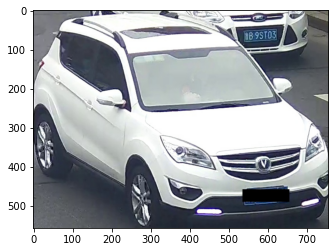

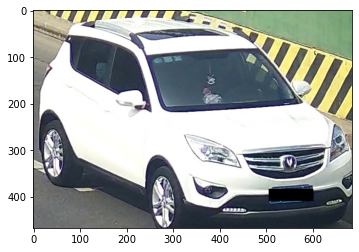

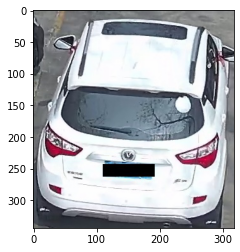

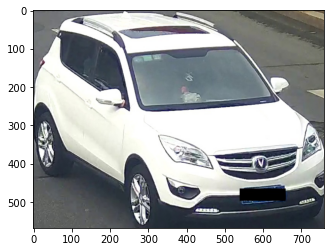

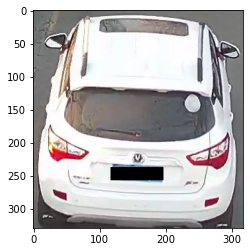

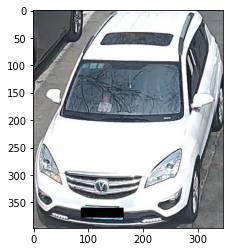

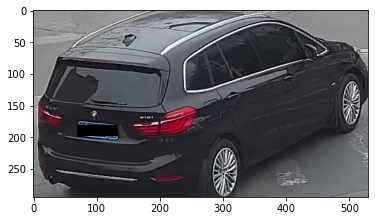

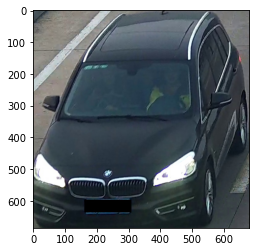

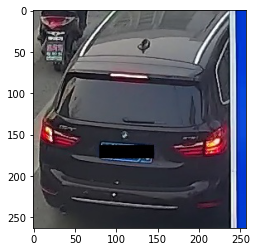

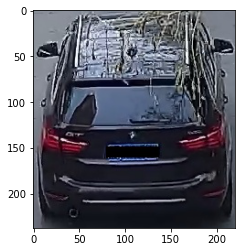

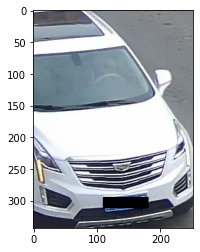

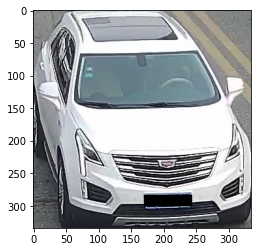

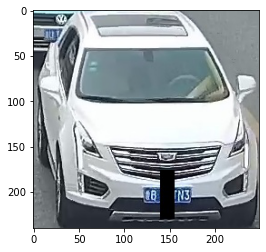

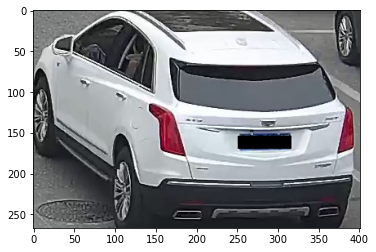

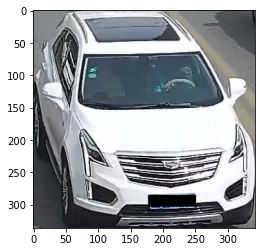

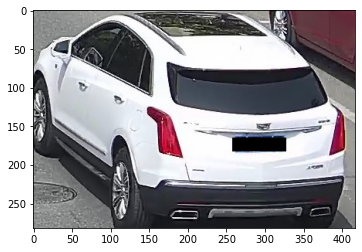

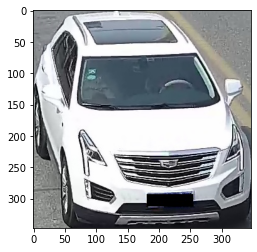

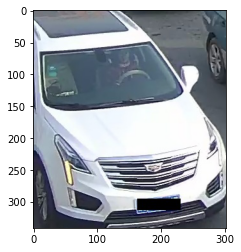

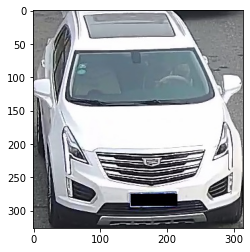

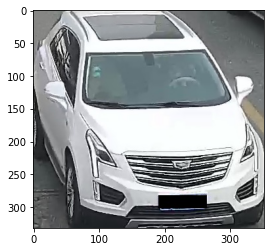

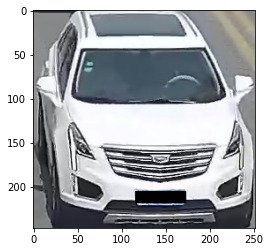

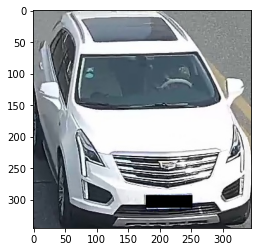

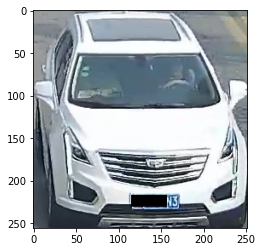

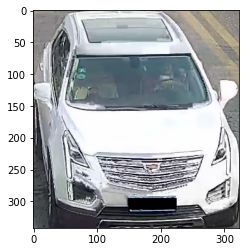

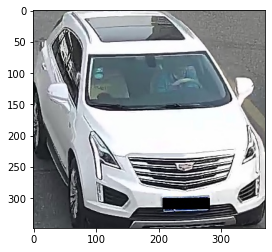

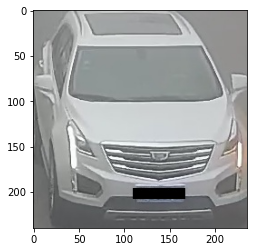

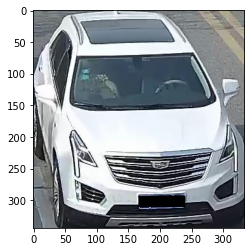

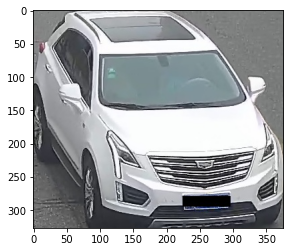

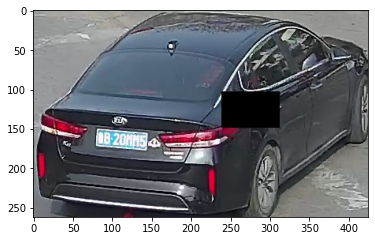

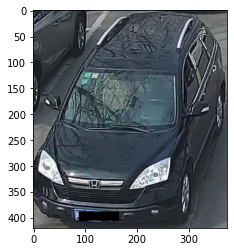

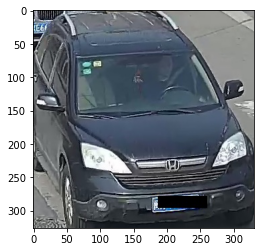

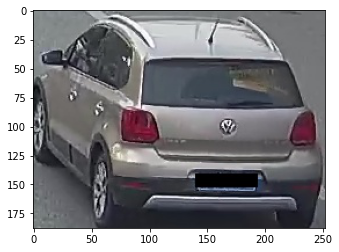

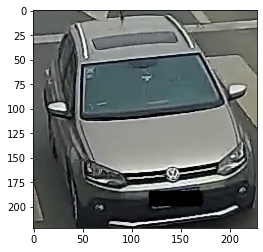

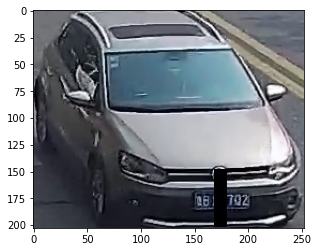

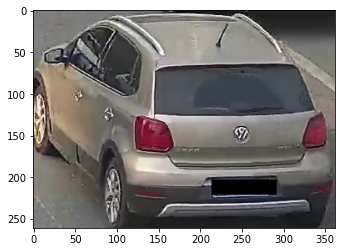

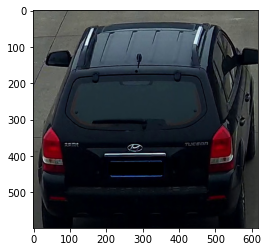

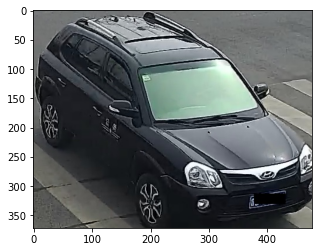

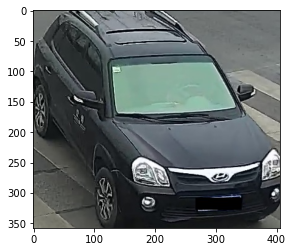

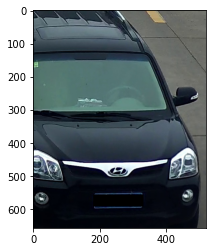

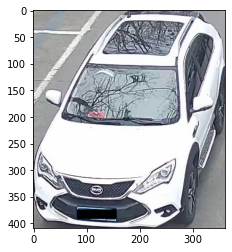

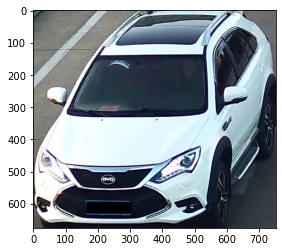

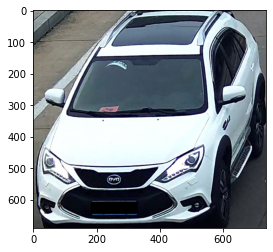

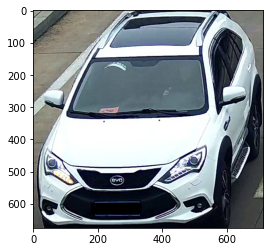

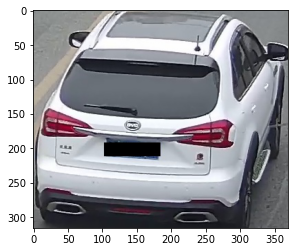

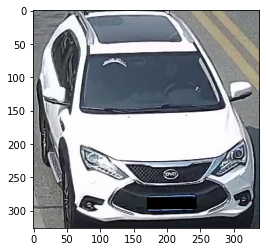

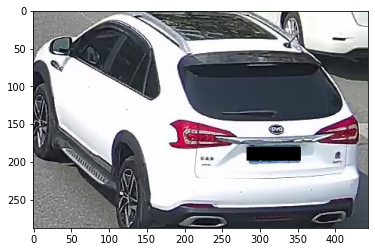

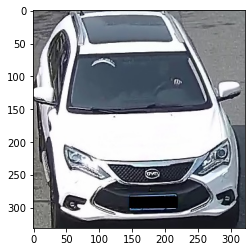

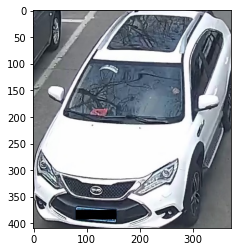

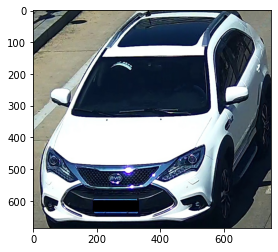

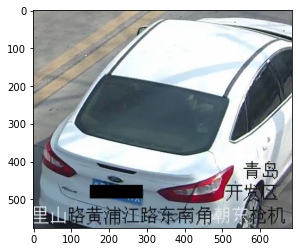

In [33]:
# 

exp_instance_labels = exp_instance.labels()
exp_instance.draw_samples( np.nonzero( exp_instance_labels == 3 )[0][:50] )

In [ ]:
%time
vdc_type_exp = MiniBatchKMeansClusteringExperiment(descriptor_file="descriptors/vdc_type.pickle")
vdc_type_exp.report_experiment()